<h1>Definição de conceitos</h1> 

<h2>O que é a Baixa Pombalina para efeitos deste problema? </h2> 


A Baixa Pombalina, no contexto deste problema, será a área delimitada onde iremos quantificar o número de cafés existentes. Para restringir a pesquisa ao limite geográfico pretendido, utilizaremos as ferramentas da API TomTom para definir a área através de polígonos georreferenciados.


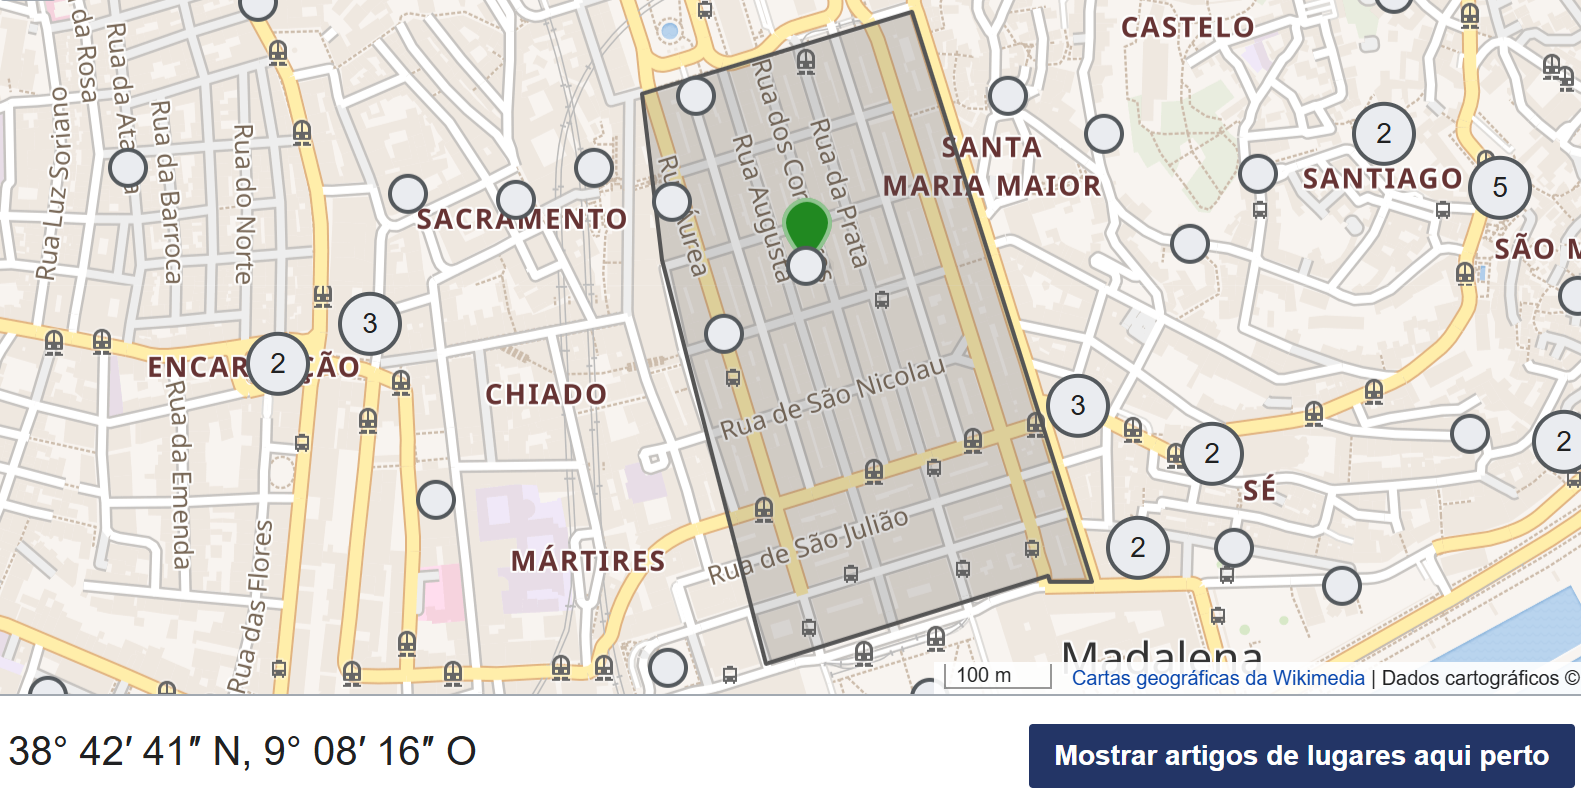


<h2>O que é uma café para efeitos deste problema?</h2> 

Para efeitos deste problema, um "café" será considerado qualquer estabelecimento comercial identificado na API TomTom como um local destinado ao consumo de café, excluindo restaurantes. Estes estabelecimentos incluem:

<ul>
    <li>Cafetarias</li>
    <li>Pastelarias</li>
    <li>Espaços que ofereçam serviços de café</li>
    <li>Outros locais destinados a pequeno-almoço ou lanches</li>
</ul>

<h1>Importação de Livrarias</h1>

In [8]:
import requests
import pandas as pd

In [16]:
# Endereço Api Categorias Possiveis Pontos de Interesse
url = "https://api.tomtom.com/search/2/poiCategories.json"
params = {
    "key": "hG3Y0C8v2Y4qEqLegXA7oF6HcpYqGKho"  
}


# Lista de palavras-chave Que identificam uma categoria de pontos de interesse do tipo café
keywords = [
    "Café","Coffee", "Bakery","Cafe", "Cafeteria", "Pub", "Breakfast", "Snack",
    "Tea", "Pastry", "Lounge", "Doughnut", "Dessert", "Bistro", "Espresso", "Bar"
]

# Chamada à API
response = requests.get(url, params=params)

# Verificar se chamada bem-sucedida
if response.status_code == 200:
    data = response.json()  # Obter a resposta em formato JSON

    # Extrair categorias
    categories = data.get("poiCategories", [])
    
    # Extrair conteudo: ids , nomes e sinonimos

    extracted_data = []
    for category in categories:
        if any(keyword.lower() in (category.get("name", "").lower() + " " + " ".join(category.get("synonyms", [])).lower()) for keyword in keywords):
            item = {
            "id": category.get("id"),
            "name": category.get("name"),
            "synonyms": category.get("synonyms", [])
            }
            extracted_data.append(item)
    
    # Criar o dataframe
    df = pd.DataFrame(extracted_data)
    
    print(df)

    # Guardar o dataframe em um ficheiro CSV
    df.to_csv("categorias.csv", index=False)
    
else:
    print(f"Erro na chamada da API: {response.status_code}")

 

         id                              name  \
0      9376                          Café/Pub   
1      9932                    Public Amenity   
2      9942        Public Transportation Stop   
3   9379004                               Bar   
4   7315005               Barbecue Restaurant   
5   7314002                   B&B/Guest House   
6   7315007                            Bistro   
7   7318006                   Cabaret Theater   
8   9376002                              Café   
9   7315147                         Cafeteria   
10  9379006                      Cocktail Bar   
11  9376006                       Coffee Shop   
12  9379009                       Comedy Club   
13  7315079               Doughnut Restaurant   
14  9361018                            Bakery   
15  9376004                     Internet Café   
16  9379008                         Jazz Club   
17  9379010                      Karaoke Club   
18  9361068                        Nail Salon   
19  8099008         